# Verification experiment - NARX


I generate data according to a NARX model and recover parameters using both a FEM estimator and an RLS estimator. The estimators are validated with a simulation error experiment.

In [156]:
using Revise
using ProgressMeter
using LinearAlgebra
using Plots
pyplot();

## Data generation

In [225]:
# Orders
deg = 1
M1 = 2
M2 = 2
M = M1+1+M2
# N = (M1+1+M2)*deg + 1
N = M1+1+M2

# Parameters
τ_true = 1e3
θ_true = 2e-1 .*randn(N,)

# Time horizon
S = 200
T = 400

# Nonlinearity
# C = zeros(M,1); for d=1:deg; C = hcat(d .*Matrix{Float64}(I,M,M), C); end
# ϕ(x::Array{Float64,1}) = [prod(x.^C[:,k]) for k = 1:size(C,2)]
ϕ(x::Array{Float64,1}) = x

# Input frequency and amplitude
ω = 1/(2*π)
A = range(0.99, stop=1.00, length=T)

# Observation array
input = zeros(T,)
output = zeros(T,)
errors = zeros(T,)

# First outputs
output[1:M1] .= 0.0

for k = 1:T
    
    # Input
    input[k] = A[k]*cos(ω*k)
    
    # Generate noise
    errors[k] = sqrt(inv(τ_true))*randn(1)[1]
   
    # Output
    if k < M
        output[k] = input[k] + errors[k]
    else
        # Update history vectors
        x_kmin1 = output[k-1:-1:k-M1]
        z_kmin1 = input[k-1:-1:k-M2]
        
        # Compute output
        output[k] = θ_true'*ϕ([x_kmin1; input[k]; z_kmin1]) + errors[k]
    end
end

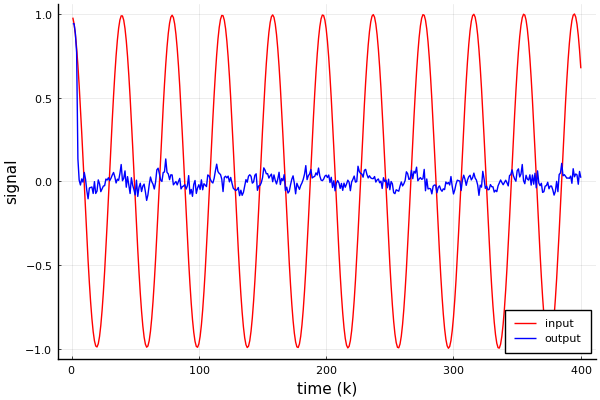

In [226]:
if T > 500
    plot(1:500, input[1:500], color="red", label="input", xlabel="time (k)", ylabel="signal")
    plot!(1:500, output[1:500], color="blue", label="output", xlabel="time (k)", ylabel="signal")
else
    tt = 1
    plot(1:tt:T, input[1:tt:T], color="red", label="input", xlabel="time (k)", ylabel="signal")
    plot!(1:tt:T, output[1:tt:T], color="blue", label="output", xlabel="time (k)", ylabel="signal")
end

Split into training and validation sets.

In [227]:
# Select training set
ix_trn = Array{Int64,1}(10:S)
input_trn = input[ix_trn]
output_trn = output[ix_trn]
T_trn = length(ix_trn);

# Select validation set
ix_val = Array{Int64,1}(S+1:T)
input_val = input[ix_val]
output_val = output[ix_val]
T_val = length(ix_val);

## Inference

In [228]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov

In [229]:
using NARX

In [230]:
graph = FactorGraph()

# Observed variables
@RV x_kmin1; placeholder(x_kmin1, :x_kmin1, dims=(M1,))
@RV z_kmin1; placeholder(z_kmin1, :z_kmin1, dims=(M2,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(N,)), placeholder(:v_θ, dims=(N,N)))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Likelihood
@RV y_k ~ NAutoregressiveX(θ, x_kmin1, u_k, z_kmin1, τ, g=ϕ)
placeholder(y_k, :y_k)

ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 17887543886481740840 -->
 
 17887543886481740840 
 
 placeholder_y_k 
 
<!-- 582057625063485984 -->
 
 582057625063485984 
 
 NARX 
 nautoregressivex_1 
 
<!-- 17887543886481740840--582057625063485984 -->
 
 17887543886481740840--582057625063485984 
 
 y_k 
 1 y 
 1 out 
 
<!-- 9705150278450992237 -->
 
 9705150278450992237 
 
 placeholder_m_θ 
 
<!-- 6697685471253737072 -->
 
 6697685471253737072 
 
 placeholder_b_τ 
 
<!-- 9945168467771511592 -->
 
 9945168467771511592 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 9945168467771511592--9705150278450992237 -->
 
 9945168467771511592--9705150278450992237 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 15529214851099475982 -->
 
 15529214851099475982 
 
 placeholder_v_θ 
 
<!-- 9945168467771511592--15529214851099475982 -->
 
 9945168467771511592--15529214851099475982 
 
 v_θ 
 1 out 
 3 v 
 
<!-- 582057625063485984--9945168467771511592 -->
 
 582057625063485984--9945168467771511592 
 
 θ 
 1 out 
 2 θ 
 
<!-- 15572772313491759574 -->
 
 15572772313491759574 
 
 placeholder_z_kmin1 
 
<!-- 582057625063485984--15572772313491759574 -->
 
 582057625063485984--15572772313491759574 
 
 z_kmin1 
 1 out 
 5 z 
 
<!-- 10921827079177628094 -->
 
 10921827079177628094 
 
 placeholder_u_k 
 
<!-- 582057625063485984--10921827079177628094 -->
 
 582057625063485984--10921827079177628094 
 
 u_k 
 1 out 
 4 u 
 
<!-- 2084281459464823134 -->
 
 2084281459464823134 
 
 placeholder_x_kmin1 
 
<!-- 582057625063485984--2084281459464823134 -->
 
 582057625063485984--2084281459464823134 
 
 x_kmin1 
 1 out 
 3 x 
 
<!-- 16242588496649234092 -->
 
 16242588496649234092 
 
 Gam 
 gamma_1 
 
<!-- 582057625063485984--16242588496649234092 -->
 
 582057625063485984--16242588496649234092 
 
 τ 
 1 out 
 6 τ 
 
<!-- 16242588496649234092--6697685471253737072 -->
 
 16242588496649234092--6697685471253737072 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 15813560137406593074 -->
 
 15813560137406593074 
 
 placeholder_a_τ 
 
<!-- 16242588496649234092--15813560137406593074 -->
 
 16242588496649234092--15813560137406593074 
 
 a_τ 
 1 out 
 2 a

In [231]:
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q)
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

In [232]:
# Preallocate parameter arrays
params_θ = (zeros(T_trn,N), zeros(T_trn,N,N))
params_τ = (zeros(T_trn,1), zeros(T_trn,1))

# Initialize priors
θ_k = (zeros(N,), 5 .*Matrix{Float64}(I,N,N))
τ_k = (1e3, 1e0)

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=θ_k[1], v=θ_k[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

# Initialize prediction arrays
predictions_FEM = (zeros(T,), zeros(T,))

@showprogress for k in ix_trn
    
    # Update history vectors
    x_kmin1 = output[k-1:-1:k-M1]
    z_kmin1 = input[k-1:-1:k-M2]
    
    ϕx = ϕ([x_kmin1; input[k]; z_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*θ_k[2]*ϕx + inv(τ_k[1] / τ_k[2])
    
    # Set data 
    data = Dict(:y_k => output[k],
                :u_k => input[k],
                :x_kmin1 => x_kmin1,
                :z_kmin1 => z_kmin1,
                :m_θ => θ_k[1],
                :v_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])
    
    # Iterate updates
    for n = 1:10
        stepθ!(data, marginals)
        stepτ!(data, marginals)
    end    
    
    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafeCov(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
    
    # Store params
    params_θ[1][k-ix_trn[1]+1,:] = θ_k[1]
    params_θ[2][k-ix_trn[1]+1,:,:] = θ_k[2]
    params_τ[1][k-ix_trn[1]+1] = τ_k[1]
    params_τ[2][k-ix_trn[1]+1] = τ_k[2]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


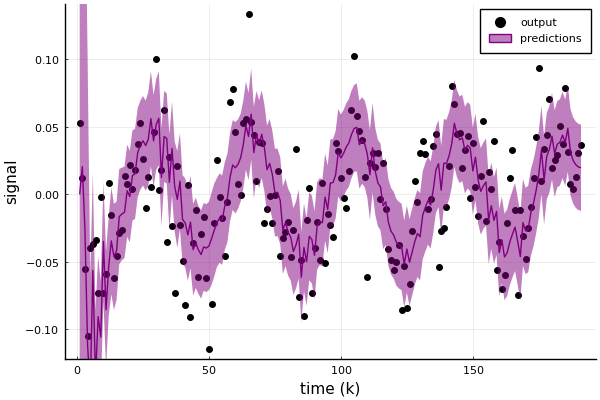

In [233]:
if T > 500
    scatter(ix_trn[1]:ix_trn[500], output[ix_trn[1]:ix_trn[500]], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=[minimum(output[ix_trn[1]:ix_trn[500]]), maximum(output[ix_trn[1]:ix_trn[500]])])
    plot!(ix_trn[1]:ix_trn[500], predictions_FEM[1][ix_trn[1]:ix_trn[500]], ribbon=[sqrt.(predictions_FEM[2][ix_trn[1]:ix_trn[500]]), sqrt.(predictions_FEM[2][ix_trn[1]:ix_trn[500]])], color="purple", label="predictions")
else
    tt = 1
    scatter(output[ix_trn[1]:tt:ix_trn[end]], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=[minimum(output[ix_trn]), maximum(output[ix_trn])])
    plot!(predictions_FEM[1][ix_trn[1]:tt:ix_trn[end]], ribbon=[sqrt.(predictions_FEM[2][ix_trn[1]:tt:ix_trn[end]]), sqrt.(predictions_FEM[2][ix_trn[1]:tt:ix_trn[end]])], color="purple", label="predictions")
end

## Simulation

In [234]:
graph2 = FactorGraph()

# Observed variables
@RV x_kmin1; placeholder(x_kmin1, :x_kmin1, dims=(M1,))
@RV z_kmin1; placeholder(z_kmin1, :z_kmin1, dims=(M2,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV θ; placeholder(θ, :θ, dims=(N,))
@RV τ; placeholder(τ, :τ)

# Likelihood
@RV y_k ~ NAutoregressiveX(θ, x_kmin1, u_k, z_kmin1, τ, g=ϕ)

ForneyLab.draw(graph2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14995994676215873459 -->
 
 14995994676215873459 
 
 placeholder_θ 
 
<!-- 14769020927414856803 -->
 
 14769020927414856803 
 
 placeholder_z_kmin1 
 
<!-- 16476533419960349808 -->
 
 16476533419960349808 
 
 placeholder_τ 
 
<!-- 2252540860091297889 -->
 
 2252540860091297889 
 
 placeholder_u_k 
 
<!-- 10164279082981837581 -->
 
 10164279082981837581 
 
 placeholder_x_kmin1 
 
<!-- 18215815691192163221 -->
 
 18215815691192163221 
 
 NARX 
 nautoregressivex_1 
 
<!-- 18215815691192163221--14995994676215873459 -->
 
 18215815691192163221--14995994676215873459 
 
 θ 
 1 out 
 2 θ 
 
<!-- 18215815691192163221--14769020927414856803 -->
 
 18215815691192163221--14769020927414856803 
 
 z_kmin1 
 1 out 
 5 z 
 
<!-- 18215815691192163221--16476533419960349808 -->
 
 18215815691192163221--16476533419960349808 
 
 τ 
 1 out 
 6 τ 
 
<!-- 18215815691192163221--2252540860091297889 -->
 
 18215815691192163221--2252540860091297889 
 
 u_k 
 1 out 
 4 u 
 
<!-- 18215815691192163221--10164279082981837581 -->
 
 18215815691192163221--10164279082981837581 
 
 x_kmin1 
 1 out 
 3 x 
 
<!-- 48725521727683590092 -->
 
 48725521727683590092 
 
<!-- 48725521727683590092--18215815691192163221 -->
 
 48725521727683590092--18215815691192163221 
 
 y_k 
 1 y

In [235]:
q = PosteriorFactorization(y_k, ids=[:y_k])
algorithm = messagePassingAlgorithm()
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

In [236]:
marginals = Dict(:y_k => vague(GaussianMeanPrecision))

@showprogress for k in ix_val
    
    if k == 1
        # Update history vectors
        x_kmin1 = output[1][k-1:-1:k-M1]
        z_kmin1 = input[k-1:-1:k-M2]
    else
        # Update history vectors
        x_kmin1 = predictions_FEM[1][k-1:-1:k-M1]
        z_kmin1 = input[k-1:-1:k-M2]
    end
    
    # Set data 
    data = Dict(:u_k => input[k],
                :x_kmin1 => x_kmin1,
                :z_kmin1 => z_kmin1,
                :τ => τ_k[1]/τ_k[2],
                :θ => θ_k[1])
    
    # Iterate updates
    stepy_k!(data, marginals)
    
    # Store params
#     predictions_FEM[1][k] = unsafeMean(marginals[:y_k])
#     predictions_FEM[2][k] = unsafeCov(marginals[:y_k])
    ϕx = ϕ([x_kmin1; input[k]; z_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*θ_k[2]*ϕx + inv(τ_k[1] / τ_k[2])
    
end

## Visualization

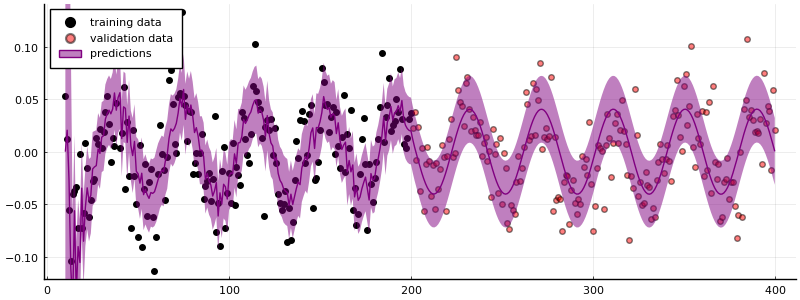

In [237]:
# Limits
ylims = [minimum(output[10:end]), maximum(output[10:end])]

# Plot training output
scatter(ix_trn[1:tt:end], output[ix_trn[1:tt:end]], color="black", ylims=ylims, label="training data", size=(800,300))

# Plot validation output
scatter!(ix_val[1:tt:end], output[ix_val[1:tt:end]], color="red", alpha=0.5, ylims=ylims, label="validation data")

# Plot fit and forecast
sdev = sqrt.(predictions_FEM[2][ix_trn[1]:tt:T])
plot!(ix_trn[1]:tt:T, predictions_FEM[1][ix_trn[1]:tt:T], ribbon=[sdev, sdev], color="purple", label="predictions")

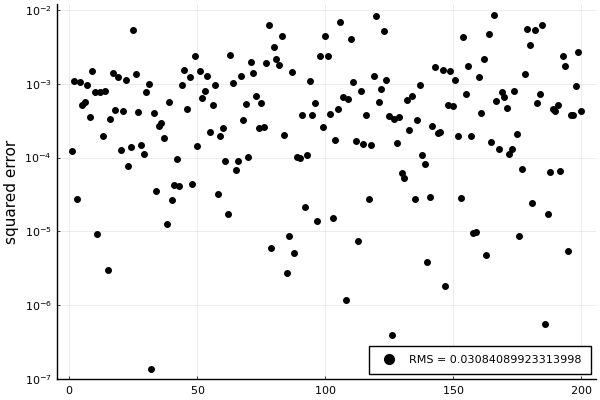

In [238]:
error_FEM = predictions_FEM[1][ix_val] - output[ix_val]
RMS_FEM = sqrt(mean(error_FEM.^2))

scatter(error_FEM.^2, label="RMS = "*string(RMS_FEM), color="black", ylabel="squared error", yscale=:log10)

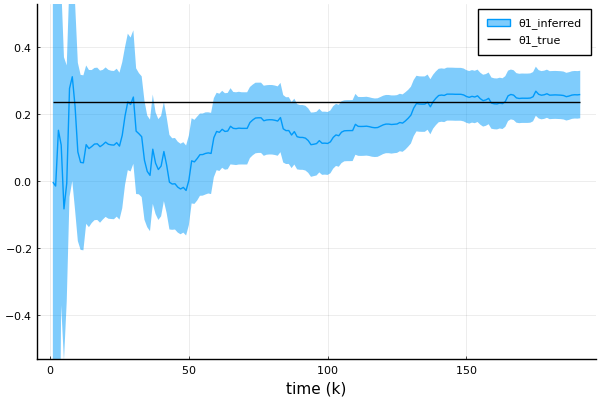

In [239]:
plot(params_θ[1][:,1], ribbon=[sqrt.(params_θ[2][:,1,1]) sqrt.(params_θ[2][:,1,1])], xlabel="time (k)", label="θ1_inferred")
plot!(θ_true[1]*ones(T_trn,), color="black", label="θ1_true", ylims=[-.5, .5])

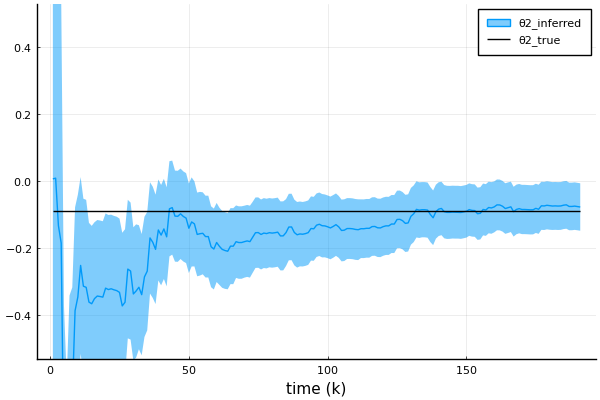

In [240]:
plot(params_θ[1][:,2], ribbon=[sqrt.(params_θ[2][:,2,2]) sqrt.(params_θ[2][:,2,2])], xlabel="time (k)", label="θ2_inferred")
plot!(θ_true[2]*ones(T_trn,), color="black", label="θ2_true", ylims=[-.5, .5])

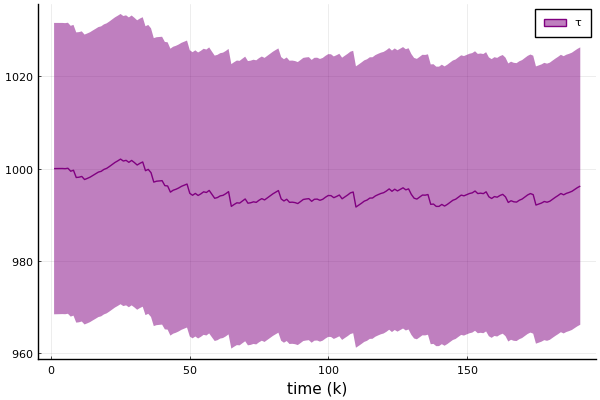

In [241]:
mτ = params_τ[1] ./ params_τ[2]
vτ = params_τ[1] ./ params_τ[2].^2

plot(mτ, ribbon=[sqrt.(vτ) sqrt.(vτ)], color="purple", xlabel="time (k)", label="τ")

## Baseline: RLS

Recursive least-squares filter ([wiki](https://en.wikipedia.org/wiki/Recursive_least_squares_filter#Recursive_algorithm)).

In [242]:
# Parameters
λ = 1.00
P = λ.*Matrix{Float64}(I,N,N)
w_k = zeros(N,);

# Track weights
w = zeros(N,T_trn)

# Preallocate prediction array
predictions_RLS = zeros(T,)

for k in ix_trn
    
    # Update data vector
    ϕx = ϕ([output[k-1:-1:k-M1]; input[k:-1:k-M2]])
    
    # Update weights
    α = output[k] - w_k'*ϕx
    g = P*ϕx*inv(λ + ϕx'*P*ϕx)
    P = inv(λ)*P - g*ϕx'*inv(λ)*P
    w_k = w_k + α*g
    
    # Prediction
    predictions_RLS[k] = w_k'*ϕx
    
    # Store weights
    w[:,k-ix_trn[1]+1] = w_k
end

In [243]:
# Simulation
for k in ix_val
    
    # Update data vector
    x = [predictions_RLS[k-1:-1:k-M1]; input[k:-1:k-M2]]
    
    # Prediction
    predictions_RLS[k] = w_k'*ϕ(x)
    
end

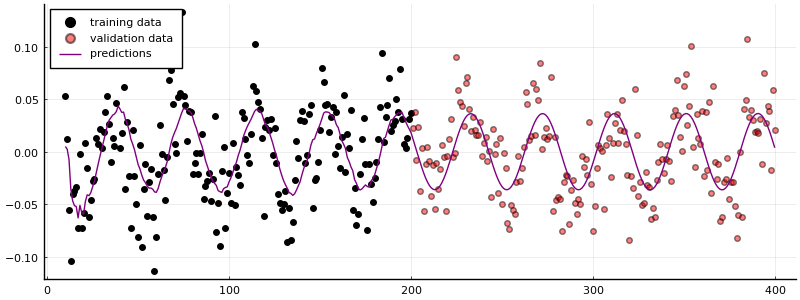

In [244]:
tt = 1

# Limits
ylims = [minimum(output[10:end]), maximum(output[10:end])]

# Plot training output
scatter(ix_trn[1:tt:end], output[ix_trn[1:tt:end]], color="black", ylims=ylims, label="training data", size=(800,300))

# Plot validation output
scatter!(ix_val[1:tt:end], output[ix_val[1:tt:end]], color="red", alpha=0.5, ylims=ylims, label="validation data")

# Plot fit and forecast
plot!(ix_trn[1]:tt:T, predictions_RLS[ix_trn[1]:tt:T], color="purple", label="predictions")

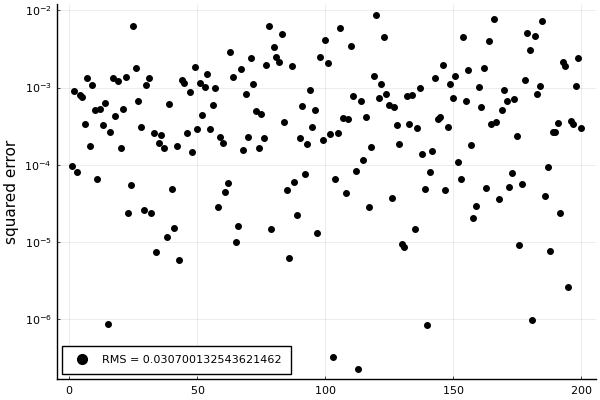

In [245]:
error_RLS = predictions_RLS[ix_val] - output[ix_val]
RMS_RLS = sqrt(mean(error_RLS.^2))

scatter(error_RLS.^2, label="RMS = "*string(RMS_RLS), color="black", ylabel="squared error", yscale=:log10)

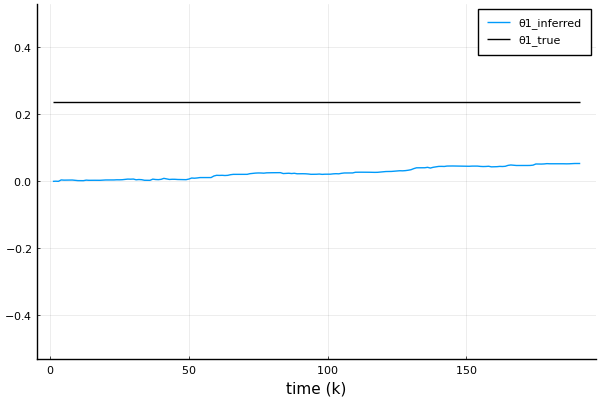

In [246]:
plot(w[1,:], xlabel="time (k)", label="θ1_inferred")
plot!(θ_true[1]*ones(T_trn,), color="black", label="θ1_true", ylims=[-.5, .5])

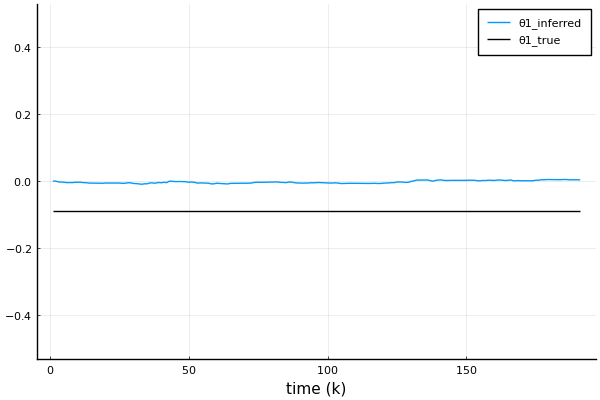

In [247]:
plot(w[2,:], xlabel="time (k)", label="θ1_inferred")
plot!(θ_true[2]*ones(T_trn,), color="black", label="θ1_true", ylims=[-.5, .5])

## Comparison

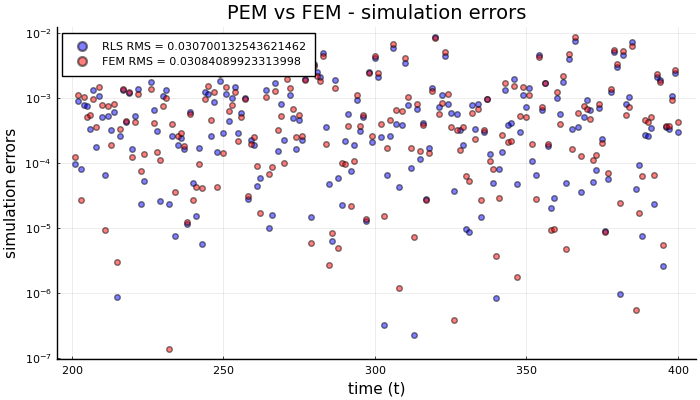

In [248]:
# Comparing simulation errors between PEM and FEM
scatter(ix_val, 
        error_RLS.^2, 
        color="blue", 
        alpha=0.5,
        markersize=4, 
        size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RLS RMS = "*string(RMS_RLS),
        legend=:topleft)
scatter!(ix_val, 
         error_FEM.^2, 
         color="red", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(RMS_FEM),
         title="PEM vs FEM - simulation errors")

In [252]:
function experiment_RLS(input, output, ix_trn, ix_val, ϕ; M1=M1, M2=M2, M=M, λ=1.00, T=100, vis=false)

    T_trn = length(ix_trn)

    # Parameters
    P = λ.*Matrix{Float64}(I,N,N)
    w_k = zeros(N,);

    # Track weights
    w = zeros(N,T_trn)

    # Preallocate prediction array
    predictions_RLS = zeros(T,)

    for k in ix_trn

        # Update data vector
        ϕx = ϕ([output[k-1:-1:k-M1]; input[k:-1:k-M2]])

        # Update weights
        α = output[k] - w_k'*ϕx
        g = P*ϕx*inv(λ + ϕx'*P*ϕx)
        P = inv(λ)*P - g*ϕx'*inv(λ)*P
        w_k = w_k + α*g

        # Prediction
        predictions_RLS[k] = w_k'*ϕx

        # Store weights
        w[:,k-ix_trn[1]+1] = w_k
    end

    # Simulation
    for k in ix_val

        # Update data vector
        x = [predictions_RLS[k-1:-1:k-M1]; input[k:-1:k-M2]]

        # Prediction
        predictions_RLS[k] = w_k'*ϕ(x)

    end

    error_RLS = predictions_RLS[ix_val] - output[ix_val]
    RMS_RLS = sqrt(mean(error_RLS.^2))

    return RMS_RLS, predictions_RLS, w
end

RMS_, p_, w_ = experiment_RLS(input, output, ix_trn, ix_val, ϕ; M1=M1, M2=M2, M=M, T=T)

(0.030700132543621462, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004961741897706255  …  0.03639651582418757, 0.03573341338005948, 0.03416702605405495, 0.03173690293138025, 0.02850442817048557, 0.024551270458924954, 0.019977319649042452, 0.014898162704492804, 0.0094421627363043, 0.0037472149432896396], [-0.0002250684394447312 0.0002963948883945276 … 0.053041118640128206 0.053166670581516404; 0.000671691020465631 0.0006204747553977527 … 0.004584840850287261 0.004347926459620246; … ; 0.006543907154933984 0.006292963233455918 … 0.007989622396789603 0.008054687130670934; 0.013906368793071805 0.015145632903904927 … -0.0705648412933564 -0.07036321633704935])

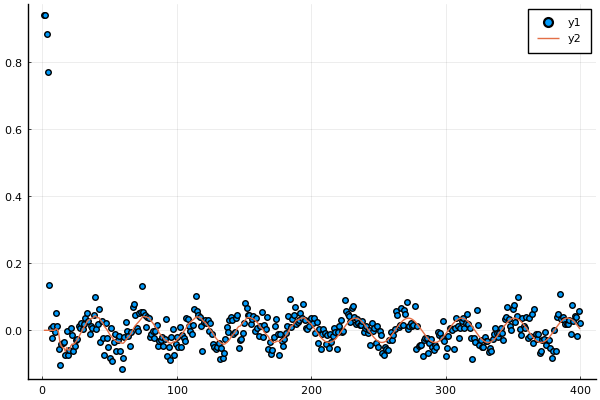

In [253]:
scatter(output)
plot!(p_)